In [17]:
%pylab inline

import gc
import fpfs
import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
import galsim
from fpfs.simutil import cosmoHSTGal
from fpfs.imgutil import gauss_kernel

Populating the interactive namespace from numpy and matplotlib


/lustre/work/xiangchong.li/ana/miniconda3/envs/cosmosis-mpich/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [132]:
ngrid  =   64
scale  =   0.168
# PSF
psfFWHM=   0.4
psfInt =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
flux_scaling=   2.587

# Galsim galaxies
directory   =   os.path.join(os.environ['homeWrk'],\
                'COSMOS/galsim_train/COSMOS_25.2_training_sample/')
catName     =   'real_galaxy_catalog_25.2.fits'
cosmos_cat  =   galsim.COSMOSCatalog(catName,dir=directory)

# catalog
cosmo252=   cosmoHSTGal('252')
cosmo252.readHSTsample()
ss  =   cosmo252.catused[0]

psf=pyfits.getdata('../../sim/galaxy_basic_psf60/psf-60.fits')
npad       =   (ngrid-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid
psfF=np.fft.fft2(np.fft.ifftshift(psfData))
gsigma=3.*2.*np.pi/64

def make_gal_image(rot,g1=0.1,g2=0.):
    gal_image=  galsim.ImageF(ngrid,ngrid,scale=scale)
    gal_image.setOrigin(0,0)

    bigfft  =   galsim.GSParams(maximum_fft_size=10240)
    # use parametric galaxies
    ang         =   rot/180.*np.pi*galsim.radians
    # each galaxy
    gal =   cosmos_cat.makeGalaxy(gal_type='parametric',\
            index=ss['index'],gsparams=bigfft)
    gal =   gal.rotate(-40./180.*np.pi*galsim.radians)
    gal =   gal.shear(g1=0.3,g2=0.)
    gal =   gal.rotate(ang)
    gal =   gal*flux_scaling
    gal =   gal.shear(g1=g1,g2=g2)
    dx  =   0.5*scale
    dy  =   0.5*scale
    gal =   gal.shift(dx,dy)
    gal =   galsim.Convolve([psfInt,gal],gsparams=bigfft)
    # draw galaxy
    gal.drawImage(gal_image,add_to_image=True)
    return gal_image.array

In [204]:
def test_knowref(img1,img2,psfF,axes,cc):
    # prepare the Gaussian smoothing kernel
    gsigma=2.5*2.*np.pi/64
    gKer,grids=gauss_kernel(ngrid,ngrid,gsigma,return_grid=True)
    k2grid,k1grid=grids
    imgF1=(np.fft.fft2(img1)/psfF)*gKer
    imgF2=(np.fft.fft2(img2)/psfF)*gKer
    imgCov1=np.fft.ifft2(imgF1).real
    imgCov2=np.fft.ifft2(imgF2).real
    dpad=26
    plt.close()
    h=img1[dpad+1:-dpad,dpad+1:-dpad]
    ax=axes[0]
    ax.contour(h,[0.1],colors=[cc, cc],origin='lower',alpha=0.8)
    #ax.imshow(img1[dpad+1:-dpad,dpad+1:-dpad],origin='lower',cmap='gray')
    ax.set_axis_off()
    ax=axes[1]
    h=img2[dpad+1:-dpad,dpad+1:-dpad]
    ax.contour(h,[0.1],colors=[cc, cc],origin='lower',alpha=0.8)
    #ax.imshow(img2[dpad+1:-dpad,dpad+1:-dpad],origin='lower',cmap='gray')
    ax.set_axis_off()
    return imgCov1[ngrid//2,ngrid//2],imgCov2[ngrid//2,ngrid//2]

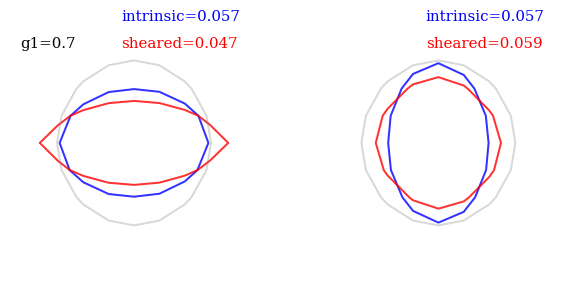

<Figure size 432x288 with 0 Axes>

In [209]:
gc.collect()
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
img1=make_gal_image(0.,g1=0.)
img2=make_gal_image(90.,g1=0.)
f1,f2=test_knowref(img1,img2,psfF,[ax1,ax2],cc='blue')
img1=make_gal_image(0.,g1=0.7)
img2=make_gal_image(90.,g1=0.7)
s1,s2=test_knowref(img1,img2,psfF,[ax1,ax2],cc='red')
gsigma=3.*2.*np.pi/64
gKer=gauss_kernel(ngrid2,ngrid2,gsigma,do_shift=True)
dpad=26
h=gKer[dpad+1:-dpad,dpad+1:-dpad]
ax1.contour(h,[0.6],colors=['gray', 'gray'],origin='lower',alpha=0.3)
ax1.text(x=5.,y=10.,s='intrinsic=%.3f' %f1,color='blue',fontsize=15)
ax1.text(x=5.,y=9.,s='sheared=%.3f' %s1,color='red',fontsize=15)
ax2.contour(h,[0.6],colors=['gray', 'gray'],origin='lower',alpha=0.3)
ax2.text(x=5.,y=10.,s='intrinsic=%.3f' %f2,color='blue',fontsize=15)
ax2.text(x=5.,y=9.,s='sheared=%.3f' %s2,color='red',fontsize=15)
ax1.text(x=1.,y=9.,s='g1=0.7' %s1,color='black',fontsize=15)
plt.tight_layout()
fig

In [197]:
f1

0.05696133557612446

In [198]:
f2

0.05698932053837547

In [199]:
s1

0.04651245285115494

In [200]:
s2

0.059415622723936926

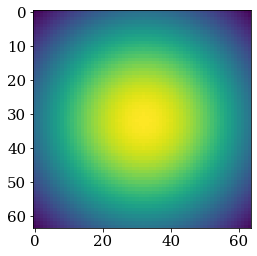

In [139]:
imshow(gKer)

In [66]:
cs.get_clim)

(0.0, 0.4)